# Recommendation Engine for E-Commerce Sales: Part 1. Data Preparation

This notebook gives an overview of techniques and services offer by SageMaker to build and deploy a personalized recommendation engine.

## Dataset

The dataset for this demo comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail). It contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. The following attributes are included in our dataset:
+ InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
+ StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
+ Description: Product (item) name. Nominal.
+ Quantity: The quantities of each product (item) per transaction. Numeric.
+ InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
+ UnitPrice: Unit price. Numeric, Product price per unit in sterling.
+ CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
+ Country: Country name. Nominal, the name of the country where each customer resides. 

Citation: Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17)

In [1]:
!pip install sagemaker==2.21.0 boto3==1.16.40

In [2]:
%store -r
%store

Stored variables and their in-db values:


In [3]:
import sagemaker
import sagemaker.amazon.common as smac
import boto3

import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack, save_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [4]:
assert sagemaker.__version__ >= "2.21.0"

In [5]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
print(f"using bucket{bucket} in region {region} \n")

## Read the data

In [6]:
df = pd.read_csv("data/Online Retail.csv")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Preprocessing

First, we check for any null (i.e. missing) values.

In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Drop any records with a missing CustomerID. If we do not know who the customer is, then it is not helpful to us when we make recommendations.

In [8]:
df.dropna(subset=["CustomerID"], inplace=True)
df["Description"] = df["Description"].apply(lambda x: x.strip())
print(df.shape)

(406829, 8)


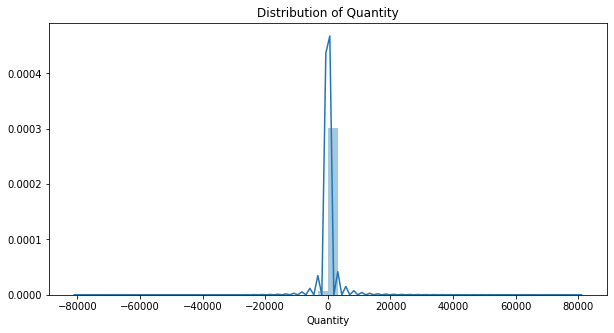

In [9]:
plt.figure(figsize=(10, 5))
sns.distplot(df["Quantity"], kde=True)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity");

Most of our quantities are realteively small (positive) numbers, but there are also some negative quantities as well as extreme outliers (both postiive and negative outliers). 

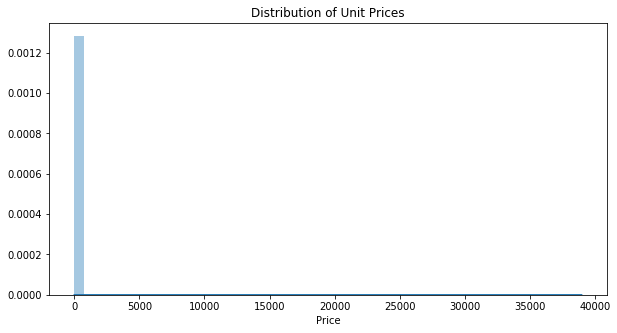

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(df["UnitPrice"], kde=True)
plt.title("Distribution of Unit Prices")
plt.xlabel("Price");

There are no negative prices, which is good, but we can see some extreme outliers.

In [11]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [12]:
df = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])[
    "Quantity"
].sum()
df = df.loc[df > 0].reset_index()
df.shape

(274399, 6)

In [13]:
def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    ohe_output = enc.fit_transform(dataframe[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    unit_price = csr_matrix((dataframe["UnitPrice"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, unit_price], format="csr", dtype="float32")

    y = dataframe["Quantity"].values.astype("float32")

    return X, y

In [14]:
X, y = loadDataset(df)

In [15]:
# display sparsity
total_cells = X.shape[0] * X.shape[1]
(total_cells - X.nnz) / total_cells

0.9991284988048746

Our data is over 99.9% sparse. Because of this high sparsity, the sparse matrix data type allows us to represent our data using only a small fraction of the memory that a dense matrix would require.

## Prepare Data For Modeling

+ Split the data into training and testing sets
+ Write the data to protobuf recordIO format for Pipe mode. [Read more](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html) about protobuf recordIO format.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219519, 9284), (54880, 9284), (219519,), (54880,))

Save numpy arrays to local storage in /data folder


In [17]:
df.to_csv("data/online_retail_preprocessed.csv", index=False)
save_npz("data/X_train.npz", X_train)
save_npz("data/X_test.npz", X_test)
np.savez("data/y_train.npz", y_train)
np.savez("data/y_test.npz", y_test)

In [18]:
prefix = "personalization"

train_key = "train.protobuf"
train_prefix = f"{prefix}/train"

test_key = "test.protobuf"
test_prefix = f"{prefix}/test"

output_prefix = f"s3://{bucket}/{prefix}/output"

In [ ]:
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = "{}/{}".format(prefix, key)
    boto3.resource("s3").Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{}/{}".format(bucket, obj)


train_data_location = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
test_data_location = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

print(train_data_location)
print(test_data_location)
print("Output: {}".format(output_prefix))

In [20]:
%store train_data_location
%store test_data_location

Stored 'train_data_location' (str)
Stored 'test_data_location' (str)


In the next notebook we will explore training and tuning.